In [17]:
from PIL import Image
import numpy as np
import pandas as pd

import sklearn as sk
from sklearn import cluster
from sklearn import linear_model
from scipy.optimize import minimize

from sklearn.cluster import KMeans

import itertools
import os
from itertools import cycle

import scipy.stats as stats
from scipy.misc import factorial

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import time
import pylab as pl
from IPython import display

import seaborn as sns

import cv2

%matplotlib inline

sns.set_style('whitegrid')
sns.set_context('poster')

# Initial boilerplate to extract the data from the .mov files in connected worlds

In [2]:
y_max = 1080 - 864
x_max = 384

def load_image( infilename ) :
    img = Image.open(infilename)
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

def save_image( npdata, outfilename ) :
    img = Image.fromarray( np.asarray( np.clip(npdata,0,255), dtype="uint8"), "L" )
    img.save( outfilename )

In [3]:
def extract_boundary(original,hsv_image, lower, upper, flag):
    # need end points of the boundary too
    mask = cv2.inRange(hsv_image, lower, upper)
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(original,original,mask= mask)
    #boundaries in gray scale
    gray = cv2.cvtColor(res,cv2.COLOR_BGR2GRAY)
    # Otsu's thresholding and gaussian filtering  to make the logs white and the background black for better detection
    ret2,th2 = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    # Otsu's thresholding after Gaussian filtering
    blur = cv2.GaussianBlur(gray,(5,5),0)
    #logs will be white in th3
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    if(flag==1):
        black, extLeft, extRight, cx,cy = find_contour(th3,original)
        return black,extLeft,extRight,cx,cy
    return th3   

#just identify water flow path for drawing graphs   
def detect_water(min_video_frame):
    hsv = cv2.cvtColor(min_video_frame, cv2.COLOR_BGR2HSV)
    # define range of green/yellow color in HSV
    lower_green = np.array([29,86,6])
    upper_green = np.array([64,255,255])
    th3 = extract_boundary(min_video_frame,hsv,lower_green, upper_green,0)    
    store = th3
    # morphing to get the skeletal structure/ medial line of the water flow    
    size = np.size(th3)    
    skel = np.zeros(th3.shape,np.uint8)    
    element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    done = False
 
    while(not done):
        eroded = cv2.erode(th3,element)
        temp = cv2.dilate(eroded,element)
        temp = cv2.subtract(th3,temp)
        skel = cv2.bitwise_or(skel,temp)
        th3 = eroded.copy()
 
        zeros = size - cv2.countNonZero(th3)
        if zeros==size:
            done = True
    return store,skel

def detect_logs(min_video_frame):
    hsv = cv2.cvtColor(min_video_frame, cv2.COLOR_BGR2HSV)
    # define range of blue color in HSV
    lower_blue = np.array([110,50,50])
    upper_blue = np.array([130,255,255])  
    
    th3 = extract_boundary(min_video_frame,hsv,lower_blue, upper_blue,0)    

    #smooth the logs (current version very fat lines)
    image ,contours, heirarchy = cv2.findContours(th3,1,2)#cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
#     print(contours)
    
    #Draw log contour + bonding rects
    colored = cv2.cvtColor(image,cv2.COLOR_GRAY2BGR) 
    count =0    
    black = np.zeros(colored.shape)
    centers=[]
    for contour in contours:
        coord_points = np.array([[p[0][0],p[0][1]] for p in contour])
        
        if len(coord_points) < 10:
            continue
            
        # TODO: if contour is really long we need to split it up
        
        mu = np.mean(coord_points, axis=0)
        cov_var = np.cov(coord_points.T)
        
        angle = np.arctan(np.linalg.eig(cov_var)[0][1]/np.linalg.eig(cov_var)[0][0])

        r, theta = convert_rec_to_polar(mu[0],y_max-mu[1])
#         image = cv2.circle(black,(cx,cy),2,(0,255,0),4)
        centers.append([r,theta,angle])

    return image,centers

In [4]:
def convert_rec_to_polar(x,y):
    assert x != 0
    theta = np.tan(y/x)
    r = np.sqrt(x**2 + y**2)
    return r, np.arctan(y/x)

def update_centers(new_sample, mu, cov):
    if mu == None:
        return np.mean(new_sample, axis=0)
    
    n = len(new_sample)
    mu_new = np.mean(new_sample, axis=0)
    sigma0_inv = np.cov(new_sample.T)
    sigma_inv = np.linalg.pinv(cov)
    
    mu_update = np.linalg.pinv(sigma_inv + n*sigma0_inv).dot(
                    sigma_inv.dot(mu) + n*sigma0_inv.dot(mu_new) )
    sigma_update = np.linalg.pinv(sigma_inv + n*sigma0_inv)
    
    return (mu_update, sigma_update)

In [5]:
cap = cv2.VideoCapture('./2017-09-07T10_39_18-0.mov')
count = 0
log_centers = []
mu, cov = None, None
while cap.isOpened():
    ret,frame = cap.read()

    if ret==True:
        store, skel = detect_water(frame[864:1080,0:384])
        logs,centers = detect_logs(frame[864:1080,0:384])   
        cv2.imwrite("frames/frame_log%04d.jpg" % count, logs)
        count = count + 1
        log_centers.append(centers)
    else:
        # The next frame is not ready, so we try to read it again
        cap.set(1, count-1)
        print("something not working")
        # It is better to wait for a while for the next frame to be ready
        cv2.waitKey(1000)

    if cv2.waitKey(10) == 27:
        break
    if cap.get(1) == cap.get(7):
        # If the number of captured frames is equal to the total number of frames,
        # we stop
        break
    if count >= 20:
        break
        
cap.release()

In [6]:
def line_centroid(r, theta1):
    x = r * np.cos(theta1)
    y = r * np.sin(theta1)
    return (x,y)

def log_points(r, theta1, theta2, length=np.arange(-5,5,0.5)):
        (x,y) = line_centroid(r, theta1)
        points = np.array([[l * np.cos(theta2) + x, l * np.sin(theta2) + y] for l in length])
        return points

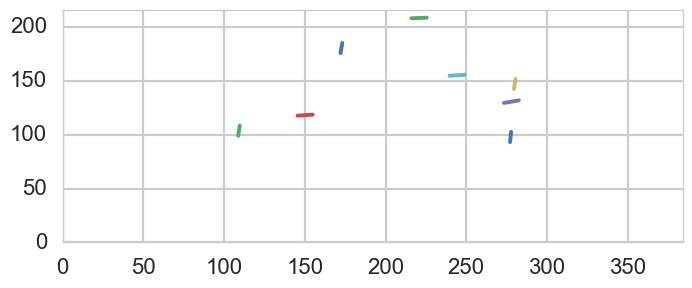

In [7]:
points = [log_points(p[0],p[1],p[2]) for p in log_centers[3]]

fig = plt.figure(figsize=(8,3))
for p in points:
    plt.plot(p[:,0], p[:,1])
plt.xlim([0,x_max])
plt.ylim([0,y_max])
plt.show()

# K-Means clustering to detect logs

Here I use K-means to cluster the log data to try and get a reasonably noise free representation of the $(r, \theta_1, \theta_2)$ coordinates of the log's positions.

In [11]:
ret,frame = cap.read()

def detect_logs(frame):
    min_video_frame = frame[864:1080,0:384]
    hsv = cv2.cvtColor(min_video_frame, cv2.COLOR_BGR2HSV)
    
    # define range of blue color in HSV
    lower_blue = np.array([110,50,50])
    upper_blue = np.array([130,255,255])  
    
    th3 = extract_boundary(min_video_frame,hsv,lower_blue, upper_blue,0)    

    #smooth the logs (current version very fat lines)
    image ,contours, heirarchy = cv2.findContours(th3,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    colored = cv2.cvtColor(image,cv2.COLOR_GRAY2BGR)
    return colored

In [12]:
# cap = cv2.VideoCapture('/Volumes/Seagate Backup Plus Drive/connected_worlds_water/water_level_4/2017-09-19T15_16_53-0.mov')

In [13]:
import copy
ret,frame = cap.read()

cap = cv2.VideoCapture('./2017-09-19T10_01_14-0.mov')

kmeans=KMeans(n_clusters=7)
main_mu = []
k = 0
log_p_filters = []
cluster_means = []
mu_old = []

while cap.isOpened():
    ret,frame = cap.read()
    logs = detect_logs(frame)

    _2d = []
    for i,row in enumerate(logs):
        for j, col in enumerate(row):
            if np.sum(col) > 0:
                _2d.append([i,j])

    _2d = np.array(_2d)
    
    # some images are coming through blank
    if len(_2d) < 20:
        continue
        
    kmeans.fit(X=_2d)

    clusters=kmeans.fit_predict(X=_2d)
    new_mus = []
    
    ordered_mus = [None]*7
    for i in range(7):
        samples = _2d[clusters == i]
        mu = samples.mean(axis=0)
        
        if len(mu_old) > 0:
            movement = np.argmin(np.linalg.norm(np.subtract(np.array(mu_old), mu), axis=1))
            mu = (np.array(mu) + np.array(mu_old[movement]))/2
#             mu = mu_old[movement]
            mu_old[movement] = [np.inf, np.inf]
    
#             ordered_mus[movement] = mu
        
        new_mus.append(mu)
#         pl.scatter(mu[0], mu[1], c='r', s=100, zorder=100)
    new_mus = np.array(new_mus)
    if k == 0:
        ordered_mus = copy.deepcopy(new_mus)
    else:
        best_order = copy.deepcopy(new_mus)
        min_cost = np.inf
        for perm in itertools.permutations(range(7), 7):
            c = np.sum([(x1-x2)**2+(y1-y2)**2 for ((x1,y1),(x2,y2)) in zip(main_mu[k-1], new_mus[np.array(perm)])])
            if c < min_cost:
                min_cost = c
                best_order = copy.deepcopy(new_mus[np.array(perm)])

        ordered_mus = best_order
        
    main_mu.append(ordered_mus)
    
    k+=1
    if k % 50 == 0:
        print(k)
#         break

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400


TypeError: 'NoneType' object is not subscriptable

In [14]:
main_mu = np.array(main_mu)
len(main_mu[:,0,0])

1425

In [18]:
## construct dataframe from logs
df = pd.DataFrame()
for i in range(7):
    df['x_%i'%i] = main_mu[:,i,0]
    df['y_%i'%i] = main_mu[:,i,1]
df.head(50)

,x_0,y_0,x_1,y_1,x_2,y_2,x_3,y_3,x_4,y_4,x_5,y_5,x_6,y_6
0,94.028037,284.289720,180.862903,65.016129,172.195876,156.773196,102.091743,77.458716,125.934959,225.861789,105.155340,263.990291,116.091743,244.825688
1,94.056075,284.149533,180.862903,65.016129,172.195876,156.773196,102.091743,77.458716,126.000000,225.702479,105.346154,263.721154,116.284404,244.477064
2,94.056075,284.149533,180.862903,65.016129,172.195876,156.773196,102.091743,77.458716,125.934959,225.861789,105.291262,263.815534,116.129630,244.731481
3,94.056075,284.149533,180.862903,65.016129,172.195876,156.773196,102.091743,77.458716,125.934959,225.861789,105.291262,263.815534,116.129630,244.731481
4,93.990476,284.361905,180.862903,65.016129,172.195876,156.773196,102.091743,77.458716,125.903226,225.943548,104.891089,264.346535,115.909910,245.180180
5,93.732484,285.114650,181.807339,64.000000,172.307692,155.723077,102.092025,77.564417,126.608392,223.902098,106.315315,261.396396,116.442478,242.752212
6,93.950920,285.343558,182.598214,63.526786,172.273504,155.726496,102.131579,77.526316,125.972028,224.944056,104.484375,264.398438,115.318182,244.645455
7,94.081761,284.628931,182.494118,63.470588,172.282828,155.575758,101.894309,77.869919,125.788462,224.288462,105.166667,263.800000,115.728070,244.745614
8,93.933775,284.496689,181.690722,64.000000,172.281818,155.790909,102.097222,77.625000,125.925000,224.206250,105.815789,262.885965,116.070796,244.398230
9,93.993590,284.192308,181.483871,63.978495,171.603175,156.769841,102.041667,77.694444,126.066667,224.293333,106.822034,261.432203,116.475728,243.533981


In [23]:
df.diff()

,x_0,y_0,x_1,y_1,x_2,y_2,x_3,y_3,x_4,y_4,x_5,y_5,x_6,y_6
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.028037,-0.140187,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.065041,-0.159309,0.190814,-0.269137,0.192661,-0.348624
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.065041,0.159309,-0.054892,0.094380,-0.154774,0.254417
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,-0.065599,0.212372,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.031734,0.081760,-0.400173,0.531001,-0.219720,0.448699
5,-0.257992,0.752745,0.944436,-1.016129,0.111816,-1.050119,0.000281,0.105702,0.705166,-2.041450,1.424226,-2.950138,0.532568,-2.427968
6,0.218436,0.228909,0.790875,-0.473214,-0.034188,0.003419,0.039554,-0.038101,-0.636364,1.041958,-1.830940,3.002041,-1.124296,1.893242
7,0.130841,-0.714627,-0.104097,-0.056197,0.009324,-0.150738,-0.237270,0.343603,-0.183566,-0.655594,0.682292,-0.598437,0.409888,0.100159
8,-0.147986,-0.132242,-0.803396,0.529412,-0.001010,0.215152,0.202913,-0.244919,0.136538,-0.082212,0.649123,-0.914035,0.342726,-0.347384
9,0.059815,-0.304381,-0.206851,-0.021505,-0.678644,0.978932,-0.055556,0.069444,0.141667,0.087083,1.006244,-1.453762,0.404932,-0.864250


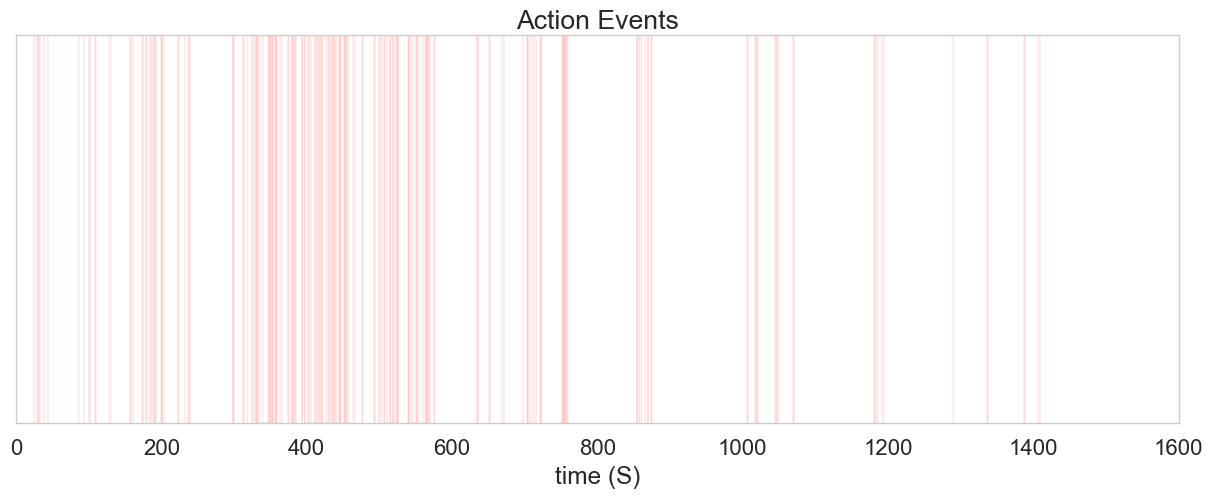

In [43]:
diff_series = (df.diff().abs() > 5).sum(axis=1) > 2
# print(np.sum(diff_series)/len(diff_series))
diff_series.to_pickle(path='diff_series.pkl')
# diff_series.plot()
# diff_series.plot()
fig, ax = plt.subplots(1,1,figsize=(15,5))

for ix,v in diff_series.iteritems():
    if v:
        ax.axvline(ix, color='r', linestyle='-', lw=0.1)

ax.set_title('Action Events')
ax.yaxis.set_visible(False)
ax.set_xlabel('time (S)')
ax.grid(False)
plt.show()

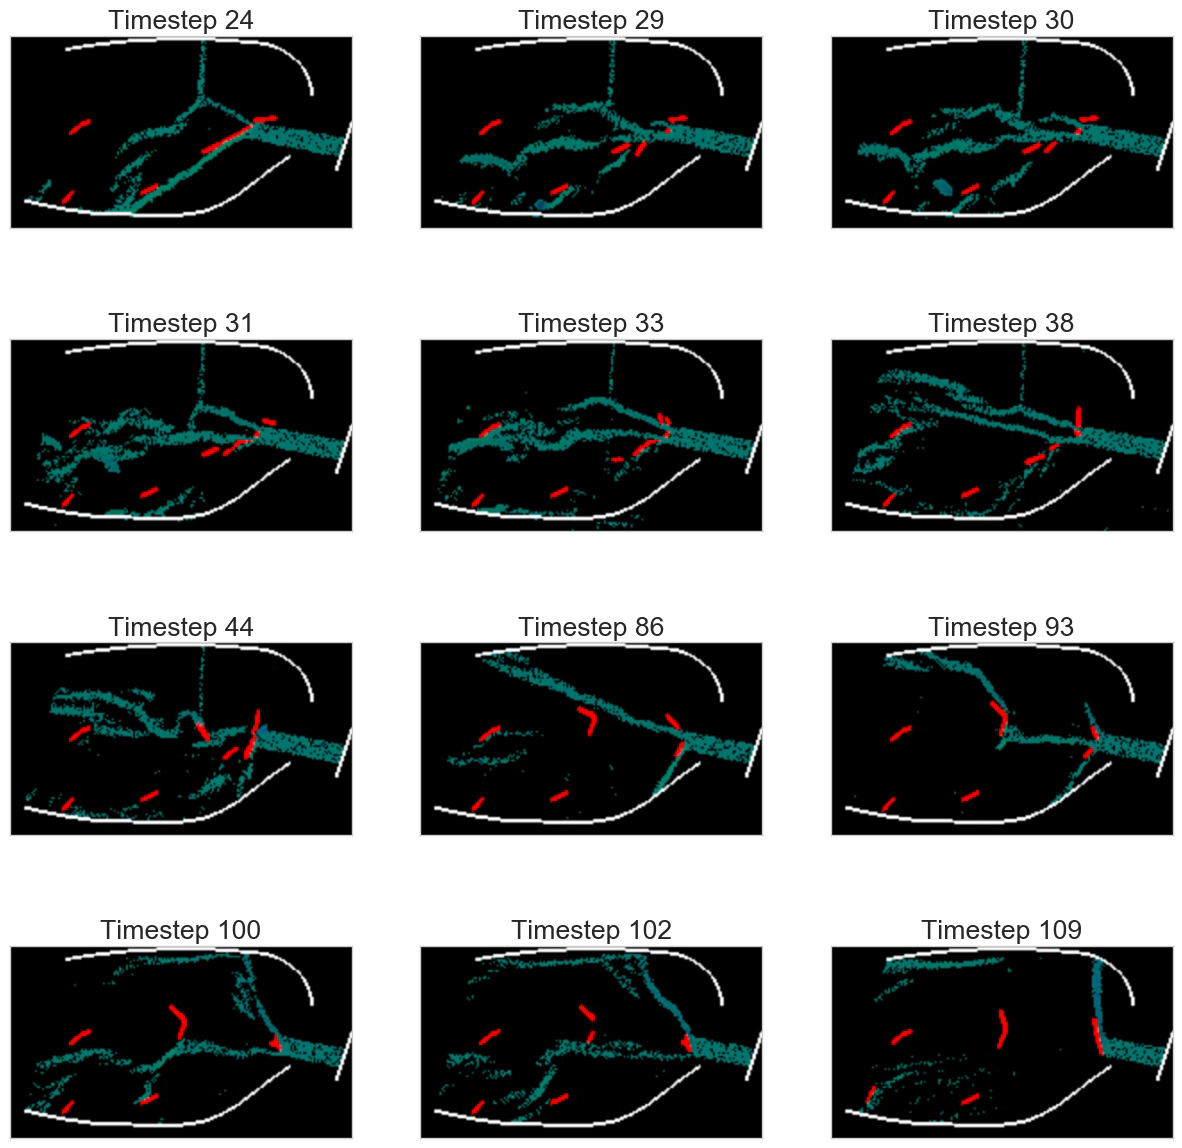

In [41]:
fig,ax = plt.subplots(4,3,figsize=(15,15))
ax = ax.flatten()

cap = cv2.VideoCapture('./2017-09-19T10_01_14-0.mov')
k = 0
j = 0

while cap.isOpened():
    ret,frame = cap.read()
    logs = detect_logs(frame)
    if diff_series.ix[k]:
        ax[j].set_title('Timestep {}'.format(k))
        ax[j].imshow(frame[864:1080,0:384])
        ax[j].grid(False)
        ax[j].xaxis.set_visible(False)
        ax[j].yaxis.set_visible(False)
        j+=1
    if j >= 12:
        break
    k+=1

# Using the Log Detection Module

The log detection module ../utils/log_detection.py is a class that will wrap all of the code that is used to detect the specific coordinates of the logs.

In [4]:
import os
import sys
import numpy as np
import pandas as pd
module_path = os.path.abspath(os.path.join('../utils/'))
if module_path not in sys.path:
    sys.path.append(module_path)
from log_detection import LogPosition

In [1]:
data_path = '/Volumes/Seagate Backup Plus Drive/connected_worlds_water/'
# interesting_file_path = 'water_level_3/2017-09-19T10_01_14-0.mov'
interesting_file_path = 'water_level_4/2017-09-19T15_16_53-0.csv'

# log_detector = LogPosition()
# log_detector.load_mov_file(data_path + interesting_file_path)
# log_detector.infer_log_positions_over_time()
# # log_detector.get_log_positions_DF()

In [2]:
# log_detector.get_actions()

In [165]:
x_sigma = 20
y_sigma = 4

def rotate(matrix, theta):
    rotation_transformation = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    return np.dot(matrix, rotation_transformation).real

class LogParticleFilter:
    
    def __init__(self, mu, cov_var):
        
        self.mu = mu
        self.cov_var = cov_var
        self.num_logs = 7
        
    def transition_model(self):
        
        angle = np.arctan(np.linalg.eig(self.cov_var)[0][1]/np.linalg.eig(self.cov_var)[0][0])
        gaussian = np.array([[x_sigma, 0],[0, y_sigma]])
        gaussian = rotate(gaussian, angle)
        self.cov_var = gaussian
        return True
    
    def filter_with_new_sample(self, new_sample):
        
        n = len(new_sample)
        try:
            probabilities = np.array([stats.multivariate_normal.pdf(s, mean=self.mu, cov=self.cov_var) for s in new_sample])
        except:
            probabilities = np.array([stats.multivariate_normal.pdf(s, mean=self.mu, cov=np.array([[x_sigma, 0],[0, y_sigma]])) for s in new_sample])

        high_probabs_args = np.argsort(probabilities)[n-n//self.num_logs:]
        
        self.mu = np.mean(new_sample[high_probabs_args], axis=0)
        self.cov_var = np.cov(new_sample[high_probabs_args].T)        

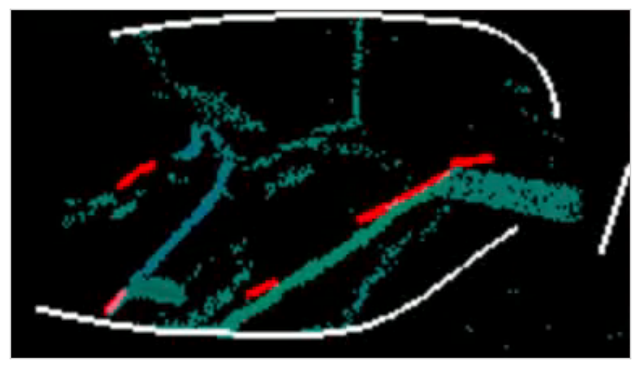

In [45]:
cap = cv2.VideoCapture('./2017-09-19T10_01_14-0.mov')

ret,frame = cap.read()

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.imshow(frame[864:1080,0:384])
ax.grid(False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

# Human time stamped data

Here I have manually time stamped the actions in the system and plotted the resulting log configurations such that we can visualise the events as a change in log positions.

In [48]:
lap_times = [29,4,10,7,9,7,12,13,6,9,11,14,9,19,4,83]
lap_times = np.cumsum(lap_times)

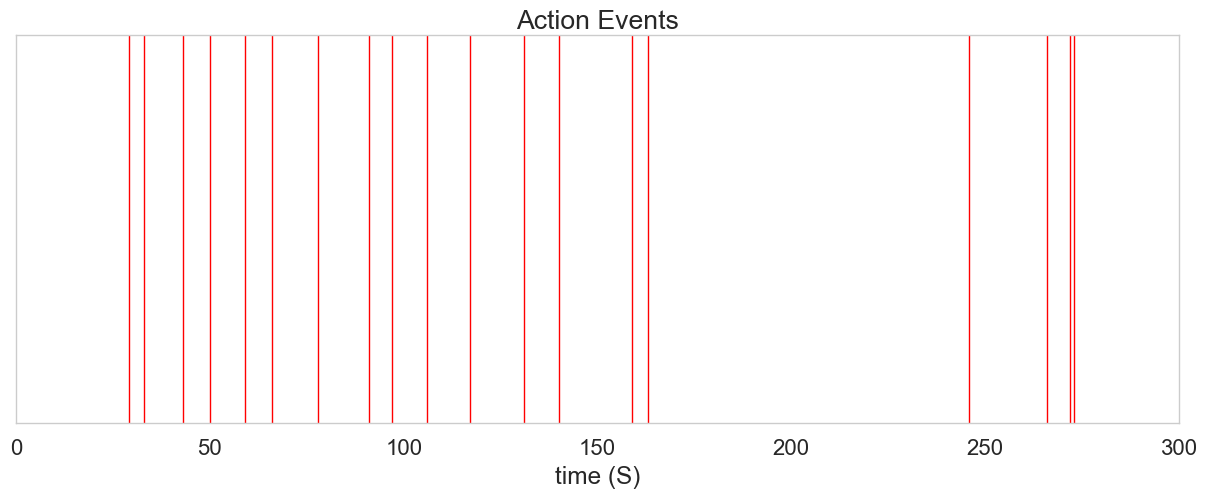

In [51]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
for i in lap_times:
    ax.axvline(i, color='r', linestyle='-', lw=1)

ax.set_title('Action Events')
ax.yaxis.set_visible(False)
ax.set_xlabel('time (S)')
ax.grid(False)
plt.show()

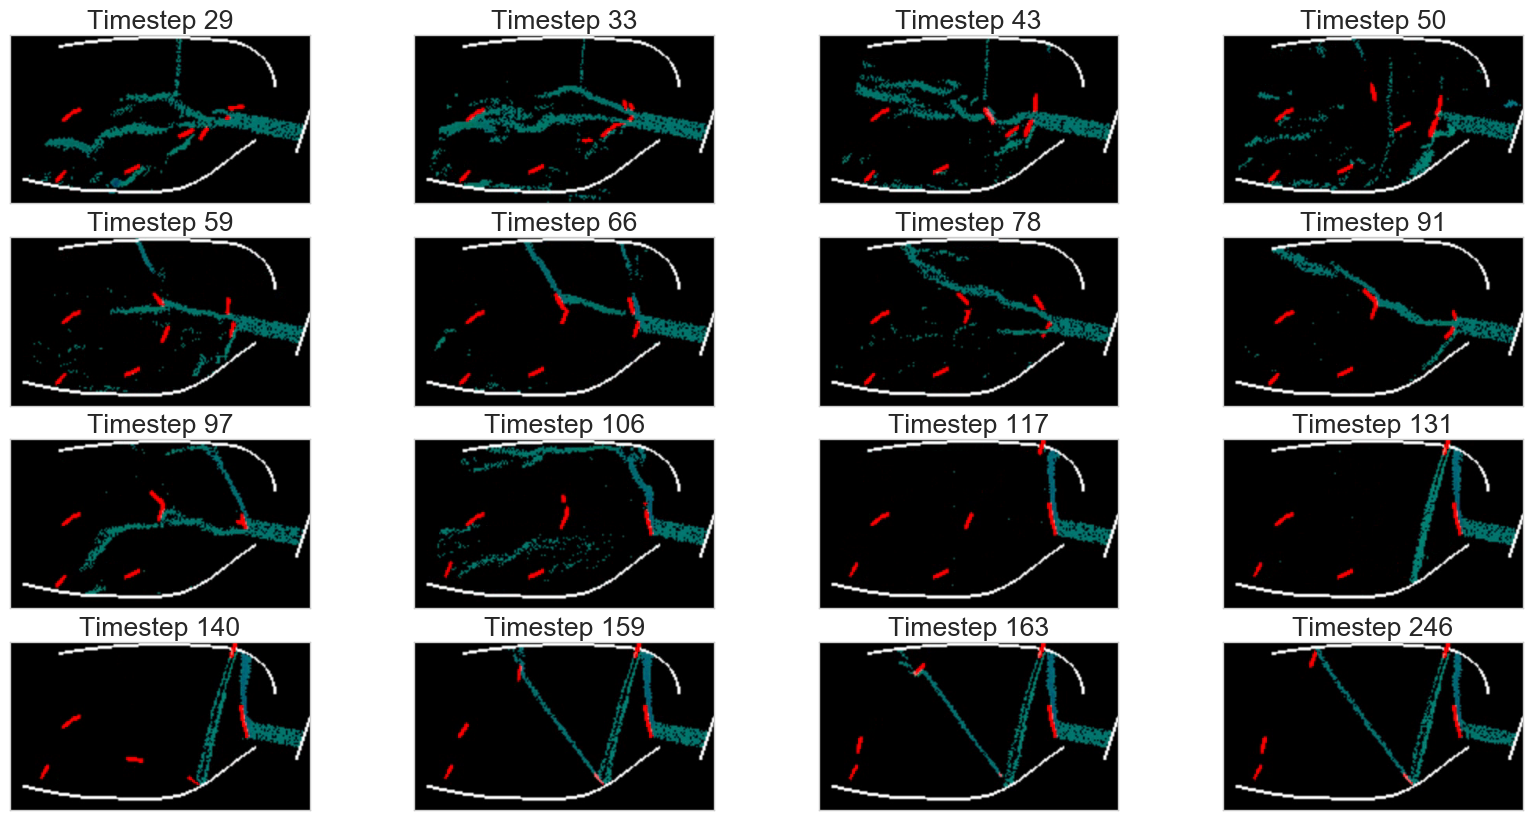

In [60]:
fig,ax = plt.subplots(4,4,figsize=(20,10))
ax = ax.flatten()

cap = cv2.VideoCapture('./2017-09-19T10_01_14-0.mov')
k = 0
j = 0

while cap.isOpened():
    ret,frame = cap.read()
    logs = detect_logs(frame)
    if k in lap_times:
        ax[j].set_title('Timestep {}'.format(k))
        ax[j].imshow(frame[864:1080,0:384])
        ax[j].grid(False)
        ax[j].xaxis.set_visible(False)
        ax[j].yaxis.set_visible(False)
        j+=1
    if j >= 16:
        break
    k+=1
    
ax[-1].grid(False)
ax[-1].xaxis.set_visible(False)
ax[-1].yaxis.set_visible(False)

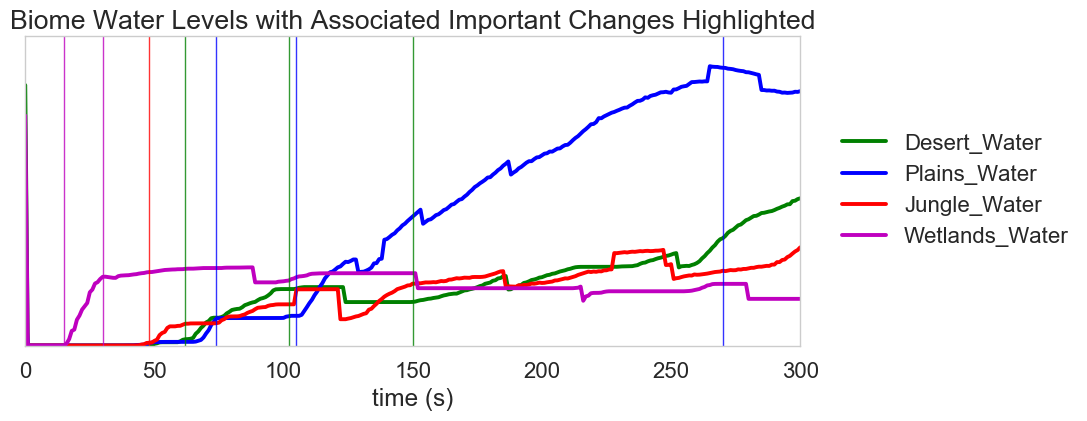

In [125]:
data = pd.read_csv('./log-0-Free_Play_Session.csv')
data.columns = data.columns.str.strip()
data = data.ix[0:300]

fig, ax = plt.subplots(1,1,figsize=(10,4))

water_subset = data[data.columns[data.columns.str.contains('Water') & (~data.columns.str.contains('Bins|Waterfall|Floor|Mountain|Reservoir'))]]
water_subset[water_subset.columns[~water_subset.columns.isin(['Total_Water'])]].plot(ax=ax, color=['g','b','r','m'])

# plains water
ax.axvline(74,color='b', lw=1,alpha=0.8)
ax.axvline(105,color='b', lw=1,alpha=0.8)
ax.axvline(270,color='b', lw=1,alpha=0.8)

# desert water
ax.axvline(62,color='g', lw=1,alpha=0.8)
ax.axvline(102,color='g', lw=1,alpha=0.8)
ax.axvline(150,color='g', lw=1,alpha=0.8)

# jungle water
ax.axvline(48,color='r', lw=1,alpha=0.8)

# wetlands water
ax.axvline(15,color='m', lw=1,alpha=0.8)
ax.axvline(30,color='m', lw=1,alpha=0.8)

ax.legend(loc='upper center', bbox_to_anchor=(1.2, 0.75))

plt.grid(False)
plt.xlabel('time (s)')
ax.yaxis.set_visible(False)
plt.title('Biome Water Levels with Associated Important Changes Highlighted')
plt.show()

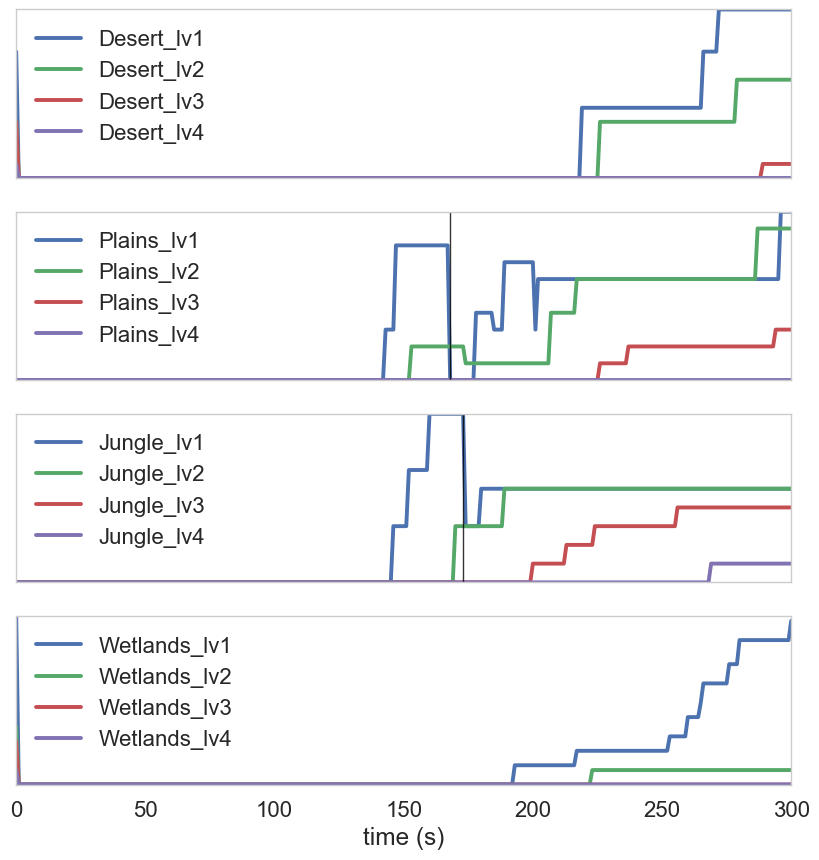

In [114]:
fig, ax = plt.subplots(4,1,figsize=(10,10))

plant_subset = data[data.columns[data.columns.str.contains('lv1|lv2|lv3|lv4') & (~data.columns.str.contains('Bins|Waterfall|Floor|Mountain|Reservoir|Dead'))]]
biomes = ['Desert','Plains','Jungle','Wetlands']
for i in range(4):
    
    plant_subset[plant_subset.columns[plant_subset.columns.str.contains(biomes[i])]].plot(ax=ax[i])
    ax[i].yaxis.set_visible(False)
    ax[i].grid(False)
    if i < 3: ax[i].xaxis.set_visible(False)
    
# plains plants
ax[1].axvline(168,color='black', lw=1,alpha=0.8)

# jungle water
ax[2].axvline(173,color='black', lw=1,alpha=0.8)

ax[i].set_xlabel('time (s)')
# plt.title('Biome Water Levels with Associated Important Changes Highlighted')
plt.show()

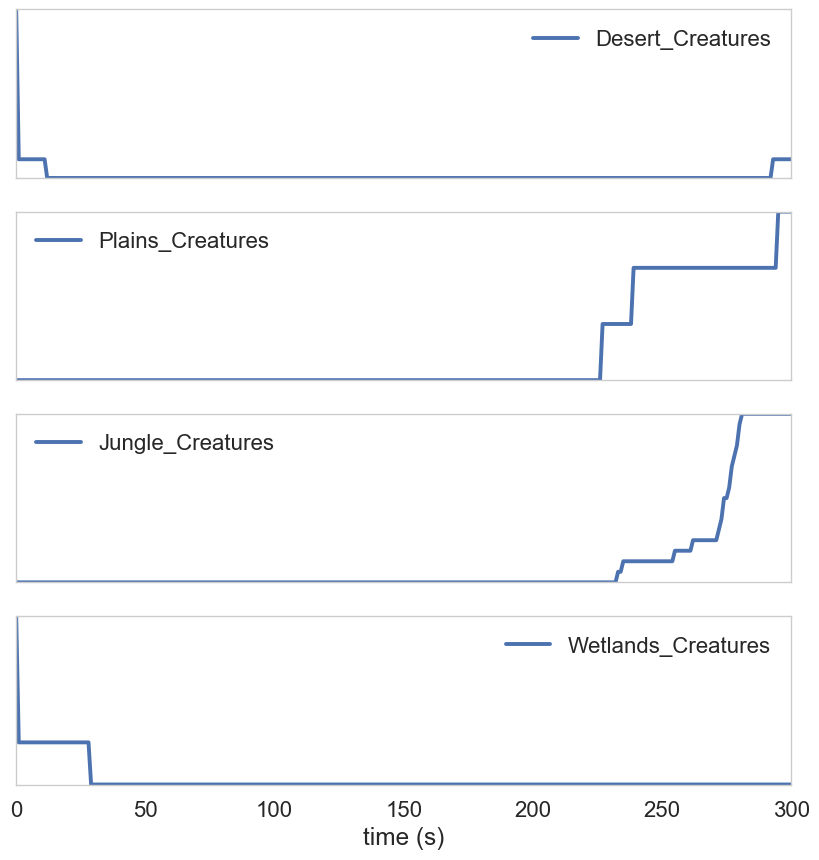

In [117]:
fig, ax = plt.subplots(4,1,figsize=(10,10))

plant_subset = data[data.columns[data.columns.str.contains('Creatures') & (~data.columns.str.contains('Bins|Waterfall|Floor|Mountain|Reservoir|Dead'))]]
biomes = ['Desert','Plains','Jungle','Wetlands']

for i in range(4):
    
    plant_subset[plant_subset.columns[plant_subset.columns.str.contains(biomes[i])]].plot(ax=ax[i])
    ax[i].yaxis.set_visible(False)
    ax[i].grid(False)
    if i < 3: ax[i].xaxis.set_visible(False)

ax[i].set_xlabel('time (s)')
# plt.title('Biome Water Levels with Associated Important Changes Highlighted')
plt.show()